# Variational Autoencoder

In this example we will be implementing a [variational autoencoder](https://arxiv.org/abs/1312.6114) using distreqx.

In [81]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

from distreqx import distributions

First, we need to create a standard small encoder and decoder module. The shapes are hard coded for the MNIST dataset we will be using.

In [82]:
class Encoder(eqx.Module):
    encoder: eqx.nn.Linear
    mean: eqx.nn.Linear
    std: eqx.nn.Linear

    def __init__(self, key, input_size=784, hidden_size=512, latent_size=10):
        keys = jax.random.split(key, 3)
        self.encoder = eqx.nn.Linear(input_size, hidden_size, key=keys[0])
        self.mean = eqx.nn.Linear(hidden_size, latent_size, key=keys[1])
        self.std = eqx.nn.Linear(hidden_size, latent_size, key=keys[2])

    def __call__(self, x):
        x = x.flatten()
        x = self.encoder(x)
        x = jax.nn.relu(x)
        mean = self.mean(x)
        log_stddev = self.std(x)
        stddev = jnp.exp(log_stddev)
        return mean, stddev


class Decoder(eqx.Module):
    ln1: eqx.nn.Linear
    ln2: eqx.nn.Linear

    def __init__(self, key, input_size, hidden_size, output_shape=784):
        keys = jax.random.split(key, 2)
        self.ln1 = eqx.nn.Linear(input_size, hidden_size, key=keys[0])
        self.ln2 = eqx.nn.Linear(hidden_size, output_shape, key=keys[1])

    def __call__(self, z):
        z = self.ln1(z)
        z = jax.nn.relu(z)
        logits = self.ln2(z)
        logits = jnp.reshape(logits, (28, 28, 1))
        return logits

Next we can construct the VAE object. It consists of an encoder and decoder, the encoder provides the mean and variance of the multivariate Gaussian prior. The output of the decoder represents the logits of a bernoulli distribution over the pixel space. Note that the `Independent` here is a bit of a legacy artifact. In general, `distreqx` encourages `vmap` based approaches to distributions and offloads any batching to the user. However, it is often possible to implicitly batch computations for certain disributions (sometimes even correctly). `Independent` is merely a helper that sums over dimensions, so even though we don't `vmap` over the bernoulli (like we often should), we can still sum over batch dimensions (since the event shape of a bernoulli is ()).

In [83]:
class VAEOutput(eqx.Module):
    variational_distrib: distributions.AbstractDistribution
    likelihood_distrib: distributions.AbstractDistribution
    image: jnp.ndarray


class VAE(eqx.Module):
    encoder: Encoder
    decoder: Decoder

    def __init__(
        self,
        key,
        input_size=784,
        latent_size=10,
        hidden_size=512,
    ):
        keys = jax.random.split(key)
        self.encoder = Encoder(keys[0], input_size, hidden_size, latent_size)
        self.decoder = Decoder(keys[1], latent_size, hidden_size, input_size)

    def __call__(self, x, key):
        keys = jax.random.split(key)
        x = x.astype(jnp.float32)

        # q(z|x) = N(mean(x), covariance(x))
        mean, stddev = self.encoder(x)
        variational_distrib = distributions.MultivariateNormalDiag(
            loc=mean, scale_diag=stddev
        )
        z = variational_distrib.sample(keys[0])

        # p(x|z) = \Prod Bernoulli(logits(z))
        logits = self.decoder(z)

        likelihood_distrib = distributions.Independent(
            distributions.Bernoulli(logits=logits)
        )

        # Generate images from the likelihood
        image = likelihood_distrib.sample(keys[1])

        return VAEOutput(variational_distrib, likelihood_distrib, image)

Now we can train our model with the standard ELBO. Keep in mind, here we require some `vmap`ing over the distribution, since we now have an additional batch dimension (that we do not want to have `Independent` sum over).

In [84]:
def load_dataset(split, batch_size):
    ds = tfds.load("binarized_mnist", split=split, shuffle_files=True)
    ds = ds.shuffle(buffer_size=10 * batch_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


@eqx.filter_jit
def loss_fn(model, key, batch):
    """Loss = -ELBO, where ELBO = E_q[log p(x|z)] - KL(q(z|x) || p(z))."""

    outputs = eqx.filter_vmap(model)(batch, key)

    # p(z) = N(0, I)
    prior_z = distributions.MultivariateNormalDiag(
        loc=jnp.zeros(latent_size), scale_diag=jnp.ones(latent_size)
    )
    # we need to make surve to vmap over the distribution itself!
    # see also: https://docs.kidger.site/equinox/tricks/#ensembling
    log_likelihood = eqx.filter_vmap(lambda x, y: x.log_prob(y))(
        outputs.likelihood_distrib, batch
    )

    kl = outputs.variational_distrib.kl_divergence(prior_z)
    elbo = log_likelihood - kl
    return -jnp.mean(elbo), (log_likelihood, kl)


@eqx.filter_jit
def update(
    model,
    rng_key,
    opt_state,
    batch,
):
    (val, (ll, kl)), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(
        model, rng_key, batch
    )
    updates, new_opt_state = optimizer.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return model, new_opt_state, val


batch_size = 128
learning_rate = 0.0005
training_steps = 1000
eval_frequency = 100
latent_size = 2

MNIST_IMAGE_SHAPE = (28, 28, 1)
optimizer = optax.adam(learning_rate)
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
model = VAE(subkey, input_size=784, latent_size=latent_size, hidden_size=512)

opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

train_ds = load_dataset(tfds.Split.TRAIN, batch_size)
valid_ds = load_dataset(tfds.Split.TEST, batch_size)

losses = []

for step in tqdm(range(training_steps)):
    key, subkey = jax.random.split(key)
    batch = jnp.array(next(valid_ds)["image"])
    subkey = jax.random.split(subkey, len(batch))
    # val_loss, (ll, kl) = loss_fn(model, subkey, batch)
    # break
    model, opt_state, loss = update(model, subkey, opt_state, batch)
    losses.append(loss)

    if step % eval_frequency == 0:
        key, subkey = jax.random.split(key)
        batch = jnp.array(next(valid_ds)["image"])
        subkey = jax.random.split(subkey, len(batch))
        val_loss, (ll, kl) = loss_fn(model, subkey, batch)
        # results = eqx.filter_jit(eqx.filter_vmap(model))(batch["image"], subkey)
        # plt.imshow(results.image[0])
        # plt.show()
        print(
            f"STEP: {step}; Validation -ELBO: {val_loss}, LL {ll.mean()}, KL \
                {kl.mean()}"
        )

2024-04-28 18:06:16.840750: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

STEP: 0; Validation -ELBO: 525.56103515625, LL -525.4020385742188, KL 0.15904900431632996
STEP: 100; Validation -ELBO: 203.7550048828125, LL -197.75645446777344, KL 5.9985527992248535
STEP: 200; Validation -ELBO: 181.37774658203125, LL -174.86788940429688, KL 6.509843349456787
STEP: 300; Validation -ELBO: 188.51040649414062, LL -182.77639770507812, KL 5.734016418457031
STEP: 400; Validation -ELBO: 175.24862670898438, LL -169.42745971679688, KL 5.82118034362793
STEP: 500; Validation -ELBO: 167.22598266601562, LL -161.6207275390625, KL 5.60526180267334
STEP: 600; Validation -ELBO: 173.36790466308594, LL -167.86239624023438, KL 5.505499839782715
STEP: 700; Validation -ELBO: 167.0419464111328, LL -161.61251831054688, KL 5.429437637329102
STEP: 800; Validation -ELBO: 173.220947265625, LL -167.77816772460938, KL 5.442760467529297
STEP: 900; Validation -ELBO: 174.1055450439453, LL -168.64964294433594, KL 5.455894947052002


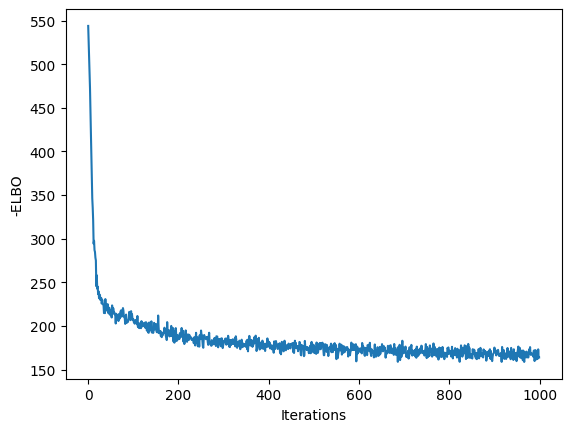

In [87]:
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("-ELBO")
plt.show()

For such a small latent space, we can visualize a nice representation of the output. 

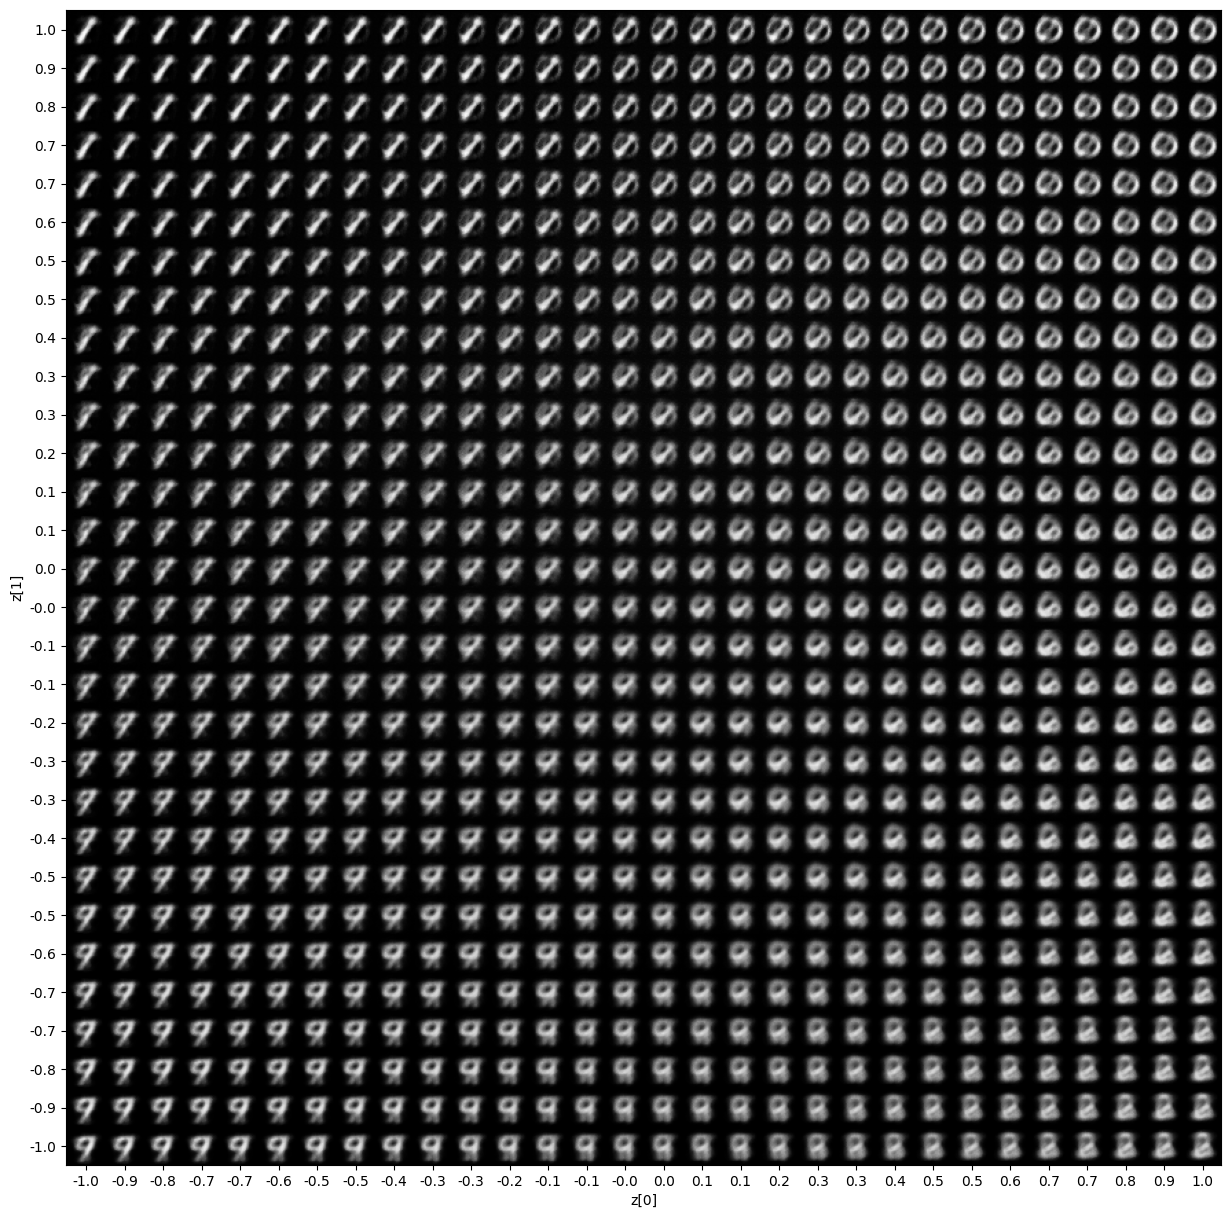

In [91]:
# from: https://keras.io/examples/generative/vae/#display-a-grid-of-sampled-digits

import numpy as np


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = jnp.linspace(-scale, scale, n)
    grid_y = jnp.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = jnp.array([xi, yi])
            # convert logits to probs
            digit = jax.nn.sigmoid(eqx.filter_jit(vae.decoder)(z_sample).squeeze())
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = jnp.arange(start_range, end_range, digit_size)
    sample_range_x = jnp.trunc(10 * grid_x) / 10
    sample_range_y = jnp.trunc(10 * grid_y) / 10
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)